# Import Libraries

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import acf
from scipy.stats import ks_2samp

# Download Data

In [23]:
class YahooFinance:
    def __init__(self, symbol:str, start_date:str, end_date:str, interval:str='1d'):
        self.symbol = symbol
        self.start_date = start_date
        self.end_date = end_date
        self.interval = interval
        self.col_names = ["date", 'price', 'log_return']
    
    def _download_data(self, symbol:str|list[str], start_date:str, end_date:str, interval:str='1d') -> pd.DataFrame:
        prices = yf.download(symbol, start=start_date, end=end_date, interval=interval, auto_adjust=False)
        prices.index = prices.index.date
        return prices
    
    def _filter_cols(self, prices:pd.DataFrame) -> pd.DataFrame:
        filtered_prices = prices['Adj Close'].copy()
        filtered_prices.columns = ['Adj Close']
        return filtered_prices
    
    def _pct_change(self, filtered_prices:pd.DataFrame) -> pd.DataFrame:
        df = filtered_prices.copy()
        df['log_return'] = np.log(df['Adj Close']/ df['Adj Close'].shift(1))
        return df
    
    def _reset_index(self, filtered_prices:pd.DataFrame) -> pd.DataFrame:
        df = filtered_prices.reset_index(names='Date', drop=False).copy()
        df['Date'] = pd.to_datetime(df['Date']).dt.strftime('%d/%m/%Y')
        df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y') #Convert from string to datetime
        return df
    
    def pipeline(self) -> pd.DataFrame:
        prices = self._download_data(self.symbol, self.start_date, self.end_date, self.interval)
        filtered_prices = self._filter_cols(prices)
        df = self._reset_index(filtered_prices)
        df = self._pct_change(df)
        df.columns = self.col_names
        df.set_index('date', drop=True, inplace=True)
        return df

In [127]:
params = {
    'symbol': 'GDX',
    'start_date': '2000-01-01',
    'end_date': '2025-12-31'
}
yahoo = YahooFinance(**params)
df = yahoo.pipeline()
df.head(5)

[*********************100%***********************]  1 of 1 completed


,price,log_return
date,,
2006-05-22,31.594477,NaN
2006-05-23,32.213970,0.019418
2006-05-24,30.991949,-0.038673
2006-05-25,32.519478,0.048112
2006-05-26,32.714661,0.005984


# Stationary Block Boostrapping (SBB)

In order to realistically simulate the SPY returns, there are two important properties that must hold: (i) Convergence in Distribution and (ii) Volatility Clustering.

Therefore, we will utilize the SBB due to the following properties:
- **Local Stationarity Holds Over Short Horizons**: The bootstrap resamples short, contiguous blocks in which the distribution of returns is approximately stable. By stitching these blocks together, it preserves short-range dependence.
- **Convergence in Distribution**: As $n \to \infty$ and $t \to \infty$ at a slower rate than $n$, the bootstrap distribution converges to the same asymptotic distribution as the original data.
- **Volatility Clustering**: Financial returns exhibit autocorrelation and breaking structure also destroys this property. However, block bootstrap preserves short-range dependence within blocks and will be at least partially preserved.

Nonetheless, there will be limitations:
- **Finite-sample issue**: With short samples or poorly chosen block length, volatility dynamics may be distorted.
- **Long-memory volatility**: Requires very large blocks, which reduces resample diversity.
- **No new volatility shocks or unseen data**: Bootstrap cannot create what was not observed.

In [128]:
def stationary_bootstrap(returns:np.ndarray, n_sims:int=1, t:int=252, avg_block_size:int=None, seed:int=None) -> np.ndarray:
    rng = np.random.default_rng(seed)
    T = len(returns)
    sims = np.zeros((n_sims, t))
    if avg_block_size is None:
        avg_block_size = int(np.floor(T**(1/3)))
    
    restart_prob = 1/avg_block_size
    
    for i in range(n_sims):
        array_idx = 0
        while array_idx < t:
            if array_idx == 0 or rng.random() < restart_prob:
                idx = rng.integers(T)
            else:
                idx = (idx + 1) % T #Implement circular indexing
            
            sims[i, array_idx] = returns[idx]
            array_idx += 1
    
    return sims

In [129]:
initial_params = {
    'returns': df['log_return'].dropna().to_numpy(),
    'n_sims': 1,
    't': 5000,
    'avg_block_size': None,
    'seed': 123
}

initial_bootstrap = stationary_bootstrap(**initial_params)
initial_bootstrap

array([[-0.0751279 , -0.01046002,  0.0278889 , ...,  0.02302252,
        -0.05556976,  0.04073123]], shape=(1, 5000))

# Automatic Block Size Selection Methodology
In block bootstrapping, increasing the block size reduces bias because larger blocks better preserve the original, long-range temporal dependence structure of the data. however, excessively large blocks reduce the number of independent resampling blocks, leading to higher variance in the bootstrap estimator. Consequently, block length selection involves a bias–variance tradeoff, and the optimal block size is chosen to be the smallest value that adequately captures the dependence structure while minimizing variance.

With that in mind and the fact that time-series data is typically dependent on previous values, we have the following notation for long-run variance:
$$\sigma^2_\infty = \gamma(0) + 2\sum^\infty_{k=1}\gamma(k)$$
where $\gamma(k) = Cov[X_0, X_k]$ and where $k$ is the lag.

## Minimize the MSE
The best expected blocksize for the SBB is determined by minimizing the MSE as denoted:
$$
\text{MSE}(\hat{\sigma}_b^2) = 
\underbrace{\text{Bias}^2}_{\text{block too short}} + 
\underbrace{\text{Variance}}_{\text{blocks too long}}
$$

Here, we can break it down into its components:
$$Bias[\hat{\sigma}^2_b] = E[\sigma^2_b] - \sigma^2_{\infty} = -\frac{1}{b}G + o\left(\frac{1}{b}\right)$$
$$V[\hat{\sigma}^2_b] = \frac{b}{N}D + o\left(\frac{b}{N}\right)$$
$$G = \sum^\infty_{k=-\infty}|k|R(k) \qquad D = 2g^2(0) \qquad g(\omega) = \sum^\infty_{s=-\infty}R(s)cos(\omega s)$$

The above equations have some confusing notations, and hence we will clarify the intent and meaning of each:
- $o\left(\frac{1}{b}\right)$ and $o\left(\frac{b}{N}\right)$ indicate that the remainder terms disappear faster than the primary terms as the sample size $N$ and block size $b$ grows.
- $\sigma^2_{\infty}$ is the true asymptotic variance of the sample mean.
- $D$ represents the variance constant for the SBB or how noisy each block-level contribution is.
- $g(\omega)$ is the spectral density function, if your process has large low-frequency power (strong persistence / volatility clustering), every block carries a lot of correlated noise.
- $R(k)$ or $R(s)$ is simply a different notation for $\gamma(k)$ and $\gamma(s)$, they have equivalent meaning.

Lastly, $G$ is harder to understand by itself. It is easier to understand if we look at how it affects the Bias term.
$$Bias[\hat{\sigma}^2_b]= -\frac{1}{b}G + o\left(\frac{1}{b}\right)$$
 
The negative sign is included because the SBB cuts the time series into chunks, destroying some correlation and that means less long-run variance, leading to an estimate that is bias downwards. Moreover, at lag $k$, dependence survive with probability $1 - \frac{|k|}{b}$ and broken with probability $\frac{|k|}{b}$. Naturally, this leads to the following weighted-sum equation:
$$Bias[\hat{\sigma}^2_b] \approx -\sum^\infty_{k=-\infty}\frac{|k|}{b}R(k)$$
$$Bias[\hat{\sigma}^2_b] \approx -\frac{1}{b}G$$

This leads us to the final MSE equation:
$$\text{MSE}(\hat{\sigma}_b^2) = \frac{G^2}{b^2} + D\frac{b}{N} + o(b^{-2}) + o(b/N)$$

If we want to minimize MSE, we would choose:
$$b = \left(\frac{2G^2}{D}\right)^{1/3} N^{1/3}$$
$$\text{MSE}(\hat{\sigma}_b^2) \approx \frac{3}{2^{2/3}}\frac{G^{2/3}D^{2/3}}{N^{2/3}}$$

## Flat-Top Lag-Window
However, we have a problem in estimating the unknown infinite sums. The authors propose the "flat-top" lag-window as it provides accurate smoothing and fast convergence rate by taking advantage of the exponential decay of autocovariance. The flat-top lag window denoted as $\lambda(t)$ is defined by its symmetric trapezoidal shape, where the "flat top" refers to the region where $∣t∣ \leq 1/2$, meaning the sample autocovariances for these lags are given a full weight of 1.

$$\hat{g}(\omega) = \sum^M_{k=-M}\lambda(k/M)\hat{R}(k)cos(\omega k)$$
$$\hat{G} = \sum^M_{k=-M}\lambda(k/M)|k|\hat{R}(k)$$
$$\hat{R}(k) = \frac{1}{N}\sum^{N-|k|}_{i=1}(X_i - \bar{X}_N)(X_{i+|k|} - \bar{X}_N)$$

$$
\lambda(t) = 
\begin{cases}
1 & \text{if } |t| \in [0, 0.5] \\
2(1 - |t|) & \text{if } |t| \in [0.5, 1] \\
0 & \text{otherwise}
\end{cases}
$$
where $t$ represents the ratio $k/M$, $k$ is the lag and $M$ is the chosen bandwidth.

Since we are truncating the infinite sum, we are introducing bias. Consequently, we aim to minimize the bias:
- **AR(p)**: By taking advantage of the fact that the autocorrelation eventually becomes negligible or dies out exponentially, $\lambda$ includes the lower lags and ignore the higher lags.
- **MA(q)**: The key property is $\gamma(k) = 0$ for all $|k| > q$. This means that if we set $M=2q$, we constrain $\lambda(k/M) \in [0, 0.5]$ because if $k$ is more than $q$ the autocovariance is 0. Hence, all relevant lags are already included.

## Adaptive Bandwidth Choice
The flat-top lag-window requires a bandwidth $M$ which the authors propose using $2\hat{m}$, where $\hat{m}$ is the point at which the smallest autocorrelation lag that is not statistically significant from 0.

Below detail the steps:
1. Let $\hat{p}(k) = \hat{R}(k)/\hat{R}(0)$.
2. For $k=1,...,K_N$, where $K_N$ is a positive, nondecreasing integer-valued function such that $K_N = o(log N)$, the recommended practical values are $c = 2$ and $K_N = \text{max}\left(5, \sqrt{log_{10}N}\right)$.
3. $\hat{m}$ is the smallest positive integar such that $|\hat{p}(\hat{m}+k)| < c\sqrt{logN/N}$, where $c>0$ is a fixed constant.
4. Set $M = 2\hat{m}$.

This has already been implemented by the authors with some modifications, and we will simply refactor the code in Python: https://public.econ.duke.edu/~ap172/opt_block_length_REV_dec07.txt

In [131]:
def adaptive_bandwidth(data:np.ndarray, c:int=2, raise_error:bool=True) -> int:
    n = len(data)
    K = max(5, np.sqrt(np.log10(n)))
    max_M = np.ceil(np.sqrt(n)) + K #Add K-lags to give some leeway
    
    threshold = c*np.sqrt(np.log10(n) / n)
    p = acf(data, nlags=max_M)[1:] #Drop lag 0
    abs_p = np.abs(p)
    is_below_threshold = abs_p < threshold
    
    for m in range(int(max_M - K)):
        if is_below_threshold[m:m+K].all():
            m_hat = m+1
            break #If break does not occur, run the else statement
    else:
        p_above_threshold = np.where(abs_p >= threshold)[0] #Index 0 selects the inner array
        m_hat = p_above_threshold.max() + 1 if p_above_threshold.size else 0 #Return the index + 1, else if there are no values >= threshold return 0
    
    if raise_error and m_hat <= 0:
        raise ValueError(f"Estimated m_hat is less than or equal to 0: {m_hat}")
    
    M = min(2*m_hat, max_M)
    return M

In [132]:
data = df['log_return'].dropna().values
print(f"Optimal adaptive bandwidth is: {adaptive_bandwidth(data)}")

Optimal adaptive bandwidth is: 2


In [133]:
def flat_top_lag_window(t:np.ndarray) -> np.ndarray:
    abs_t = np.abs(t)
    window = np.zeros_like(abs_t, dtype=float)
    window[abs_t<=0.5] = 1.0
    
    mask = (abs_t > 0.5) & (abs_t<=1.0)
    window[mask] = 2.0*(1.0-abs_t[mask])
    return window

def sample_autocovariance(data:np.ndarray, k:np.ndarray) -> np.ndarray:
    n = len(data)
    x_bar = data.mean()
    centered_x = data - x_bar
    
    R = np.zeros_like(k, dtype=float)
    for idx, lag in enumerate(k):
        abs_lag = np.abs(lag)
        R[idx] = centered_x[:n-abs_lag]@ centered_x[abs_lag:]/ n
    return R

def long_run_variance_components(data:np.ndarray, M:int) -> tuple[float, float]:
    k = np.arange(-M, M+1, dtype=int)
    lambda_vals = flat_top_lag_window(k/M)
    R_hat = sample_autocovariance(data, k)
    
    g_hat = np.sum(lambda_vals*R_hat) #cos(0) = 1
    G_hat = np.sum(lambda_vals* np.abs(k)* R_hat)
    D_hat = 2.0* g_hat**2
    return G_hat, D_hat

def optimal_stationary_block_size(data:np.ndarray, c:int=2) -> int:
    n = len(data)
    M = adaptive_bandwidth(data, c)
    G_hat, D_hat = long_run_variance_components(data, M)
    block_size = (2* G_hat**2 / D_hat)**(1/3)* n**(1/3)
    max_block_size = np.ceil(min(3*np.sqrt(n), n/3)) #Upper bound on estimated optimal block length
    return min(block_size, max_block_size)

In [137]:
avg_block_size = int(np.ceil(optimal_stationary_block_size(data**2)))
print(f"The optimal block size for squared returns is: {avg_block_size}")

The optimal block size for squared returns is: 122


# Volatility Clustering Property

In [ ]:
class VolCluster:
    def __init__(self, underlying_df:pd.Series, sims:np.ndarray, max_lag:int, alpha:float=0.05):
        self.underlying = underlying_df.copy()
        self.sims = sims.copy()
        self.max_lag = int(max_lag)
        self.alpha = alpha
    
    def _acf_results(self) -> tuple[np.ndarray, np.ndarray]:
        acf_sq_u = acf(self.underlying**2, nlags=self.max_lag)
        acf_sq_b  = np.array([acf(self.sims[i]**2, nlags=self.max_lag) for i in range(len(self.sims))])
        return (acf_sq_u, acf_sq_b)
    
    def _get_bounds(self) -> tuple[float, float]:
        interval = self.alpha*100/2
        lb, ub = interval, 100-interval
        return (lb, ub)
    
    def _bootstrap_stats(self, acf_sq_b:np.ndarray) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
        lb, ub = self._get_bounds()
        acf_sq_b_mean = acf_sq_b.mean(axis=0)
        acf_sq_b_lo = np.percentile(acf_sq_b, lb, axis=0)
        acf_sq_b_hi = np.percentile(acf_sq_b, ub, axis=0)
        return (acf_sq_b_mean, acf_sq_b_lo, acf_sq_b_hi)
    
    def plot_acf_band(self, avg_block_size:float=None) -> plt.Figure:
        acf_sq_u, acf_sq_b = self._acf_results()
        acf_sq_b_mean, acf_sq_b_lo, acf_sq_b_hi = self._bootstrap_stats(acf_sq_b)
        lags = np.arange(self.max_lag+1)
        
        base_title = "Volatility Clustering: ACF($r_t^2$)"
        title = base_title if avg_block_size is None else base_title+f' with L={avg_block_size}'
        
        plt.figure(figsize=(8,5))
        plt.fill_between(
            lags, acf_sq_b_lo, acf_sq_b_hi,
            color='lightblue', alpha=0.4, label=f'Bootstrap {100-self.alpha*100}% CI'
        )
        
        plt.plot(lags, acf_sq_b_mean, color='blue', linewidth=2, label='Bootstrap Mean ACF')
        plt.plot(lags, acf_sq_u, color='black', linestyle='--', linewidth=2, label='Underlying ACF')
        plt.axhline(0, color='gray', linewidth=1)
        
        plt.xlabel("Lag")
        plt.ylabel("ACF of squared returns")
        plt.title(str(title))
        plt.legend()
        
        plt.grid(alpha=0.3)
        plt.tight_layout()
        return plt.gcf()

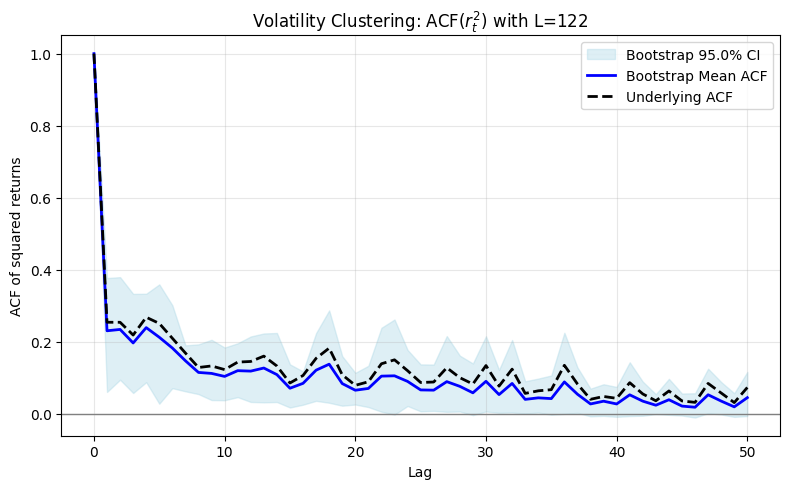

In [146]:
steps = len(data)
max_lag = 50
alpha = 0.05
seed = 123

sims = stationary_bootstrap(data, n_sims=1000, t=steps, avg_block_size=avg_block_size, seed=seed)
vc = VolCluster(data, sims, max_lag, alpha)
fig1 = vc.plot_acf_band(avg_block_size=avg_block_size)

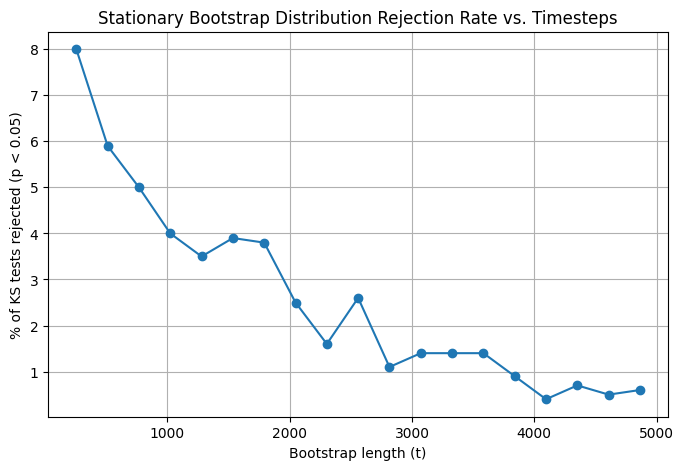

In [150]:
steps = np.arange(256, len(data), step=256)
sims = [stationary_bootstrap(data, n_sims=1000, t=s, seed=seed) for s in steps]
alpha = 0.05
rejected_counts = []

for i in sims:
    count_reject = 0
    for j in range(len(i)):
        _, pval = ks_2samp(data, i[j])
        if pval < alpha:
            count_reject += 1
    rejected_counts.append(count_reject / len(i))

plt.figure(figsize=(8,5))
plt.plot(steps, np.array(rejected_counts)*100, marker='o')
plt.xlabel("Bootstrap length (t)")
plt.ylabel("% of KS tests rejected (p < 0.05)")
plt.title("Stationary Bootstrap Distribution Rejection Rate vs. Timesteps")
plt.grid(True)
plt.show()